In [1]:
import NetworkArchitectures as nets
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from dataset_utils import Format_Dataset
from tqdm import tqdm

In [2]:
# Load in the Indianapolis Glaucoma Progression Study
data_dir = 'data/IGPS/'
results_dir = 'results/IGPS/'

features = [
    'IOP', 'MAP', 'SBP', 'DBP', 'HR', 'Qmean', 'P1', 'P2', 'P4', 'P5', 'R4', 'R5', 'trusoptBase', 'timololBase', 'Gen_Vision', 'macular_volume', 'mean_RNFL_thickness', 'Age', 'soft_green', 'soft_red', 'soft_blue', 'ProgressionStructure1', 'next_ProgressionStructure1'
]

features = [
    'IOP', 'MAP', 'SBP', 'DBP', 'HR', 'Qmean', 'P1', 'P2', 'P4', 'P5', 'R4', 'R5', 'next_ProgressionStructure1'
]

features = [
    'IOP', 'P1', 'P5', 'R4', 'cup_disk_horiz_ratio', 'mean_RNFL_thickness', 'next_ProgressionStructure1'
]

features = [
    'IOP', 'P1', 'P5', 'R4', 'Age', 'acuity', 'cup_disk_vert_ratio', 'cup_disk_horiz_ratio', 'mean_RNFL_thickness', 'next_ProgressionStructure1'
]


first, igps = True, None
for fn in sorted(os.listdir(data_dir)):
    if fn.endswith('.csv'):
        path = os.path.join(data_dir, fn)

        if first:
            igps = pd.read_csv(path)[features]  # grab only the features needed
            first = False
            continue

        df = pd.read_csv(path)[features]
        igps = pd.concat([igps, df])

# Possibly some missing data; lets fix it
def impute_col_KNN(df, col_name):
    col = df[[col_name]]
    imputer = KNNImputer(n_neighbors=5)
    col = imputer.fit_transform(col)
    df[col_name] = col

for f in features:
    impute_col_KNN(igps, f)

first_visit = pd.read_csv(data_dir + 'year0_0.csv')[features]

for f in features:
    impute_col_KNN(first_visit, f)

first_visit = first_visit.drop(columns='next_ProgressionStructure1')

igps

,IOP,P1,P5,R4,Age,acuity,cup_disk_vert_ratio,cup_disk_horiz_ratio,mean_RNFL_thickness,next_ProgressionStructure1
0,20.0,47.489951,19.316454,5689.152456,68.172485,0.14,0.490,0.464,0.28,0.0
1,18.0,41.983253,18.571021,5763.809295,68.501027,0.12,0.598,0.707,0.27,1.0
2,12.0,43.567630,19.048322,4121.464174,58.231348,-0.04,0.794,0.681,0.21,1.0
3,13.0,50.544863,20.265924,3952.890670,75.148528,0.08,0.637,0.694,0.25,1.0
4,20.0,53.856285,20.514162,5312.669706,71.887748,0.10,0.705,0.821,0.27,1.0
...,...,...,...,...,...,...,...,...,...,...
64,17.0,39.823806,18.243175,5652.671323,72.490075,-0.06,0.770,0.652,0.15,1.0
65,14.0,41.748648,18.673210,4689.228002,38.661191,0.02,0.751,0.790,0.04,1.0
66,4.0,46.703749,19.787909,2674.666564,82.762491,0.32,0.751,0.734,0.17,1.0
67,21.0,41.925701,17.987417,5940.162774,72.361396,0.38,0.890,0.948,0.18,1.0


In [3]:
# Preprocess this mess
split = int(0.8 * len(igps))
train = igps.iloc[:split]
test = igps.iloc[split:]

feat_count = len(features) - 1

train_X, train_y = train[features[:feat_count]], train[features[feat_count:]]
test_X, test_y = test[features[:feat_count]], test[features[feat_count:]]

train_X, train_y = train_X.to_numpy(), train_y.to_numpy()
test_X, test_y = test_X.to_numpy(), test_y.to_numpy()

first_visit = first_visit.to_numpy()    # the purpose of this line is to obtain the same verified clusters as we only use data from
                                        # the first visit to verify the clusters
print(train_X.shape)

# normalize the data
s = MinMaxScaler()
train_X = s.fit_transform(train_X)
test_X = s.transform(test_X)

first_visit = s.transform(first_visit)

dataset = {
    'samples': train_X,
    'labels': train_y
}

# Input layer basically
train = Format_Dataset(dataset, choice='Train')
train = torch.utils.data.DataLoader(shuffle=False, dataset=train, batch_size=10)

(496, 9)


In [4]:
'''params = {
    'k': 5,
    'data': first_visit,
    'sigma': 0.75,
    'mode': 2
}

rbf = nets.RBF(**params)
loss_fn = nn.BCELoss()
sgd = optim.Adam(rbf.parameters(), lr=0.01)

list(rbf.parameters())'''

"params = {\n    'k': 5,\n    'data': first_visit,\n    'sigma': 0.75,\n    'mode': 2\n}\n\nrbf = nets.RBF(**params)\nloss_fn = nn.BCELoss()\nsgd = optim.Adam(rbf.parameters(), lr=0.01)\n\nlist(rbf.parameters())"

Training... :   0%|          | 0/2000 [00:00<?, ?it/s]/Users/mikeyjoyce/Documents/Grad School/NeuralNets/Project1/NetworkArchitectures.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.exp(-torch.pow(torch.tensor(x, dtype=torch.float64).unsqueeze(1) - self.centers, 2).sum(dim=2) / (2 * self.covar**2))
Training... :   0%|          | 0/2000 [00:00<?, ?it/s]/Users/mikeyjoyce/Documents/Grad School/NeuralNets/Project1/NetworkArchitectures.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.exp(-torch.pow(torch.tensor(x, dtype=torch.float64).unsqueeze(1) - self.centers, 2).sum(dim=2) / (2 * self.covar**2))
Training... :   0%|          | 0/2000 [00:00<?, ?it/s]/Use

K =  18


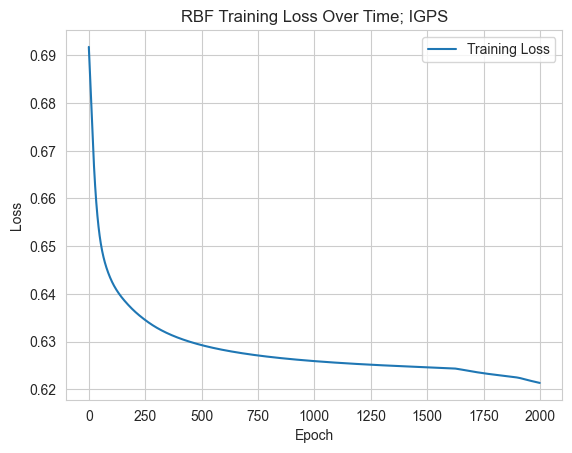

In [5]:
final, last, final_loss, k= None, -1, None, 0
for z in range(1, 30):
    train = Format_Dataset(dataset, choice='Train')
    train = torch.utils.data.DataLoader(shuffle=False, dataset=train, batch_size=6)

    params = {
        'k': z,
        'data': first_visit,
        'sigma': 0.75,
        'mode': 1,
        'n_perceptrons': 1
    }

    rbf = nets.RBF(**params)
    loss_fn = nn.BCELoss()
    sgd = optim.Adam(rbf.parameters(), lr=0.001)

    epochs = 2000

    loss_vals = []
    for epoch in tqdm(range(epochs), 'Training... '):
        temp_loss = []
        for samples, labels in train:
            output = rbf(samples)
            loss = loss_fn(output, labels)

            sgd.zero_grad()
            loss.backward()
            sgd.step()

            temp_loss.append(loss.item())

        loss_vals.append(sum(temp_loss[-len(train):]) / len(train))

    rbf.eval()
    with torch.no_grad():
        out = rbf(torch.tensor(test_X)).detach().numpy()

    preds = []
    for i in range(len(out)):
        preds.append(np.round(out[i]))

    truth = list(test_y)
    f1 = f1_score(truth, preds)

    if last == -1:
        final = rbf
        last = f1
        final_loss = loss_vals
        k = z
    elif f1 > last:
        final = rbf
        last = f1
        final_loss = loss_vals
        k = z

print('K = ', k)
plt.plot(final_loss, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('RBF Training Loss Over Time; IGPS')
plt.legend()
plt.savefig(results_dir + 'RBFloss_k=' +str(k)+ '.png', dpi=900)
plt.show()

In [12]:
rbf.eval()
with torch.no_grad():
    out = rbf(torch.tensor(test_X)).detach().numpy()

#print("RBF neural network output: ", out)
print(list(rbf.parameters()))

preds = []
for i in range(len(out)):
    if out[i] >= 0.5:
        preds.append(1)
    else:
        preds.append(0)

preds

[Parameter containing:
tensor([0.3600, 0.1742, 0.2899, 0.0397, 0.6443, 0.1517, 0.1292, 0.4140, 0.5878,
        1.0505, 0.6570, 1.5778, 0.2168, 0.2225, 0.2157, 0.2914, 0.2568, 0.2260,
        0.5135, 0.6618, 0.1193, 0.1428, 0.3812, 0.3260, 0.1133, 0.1794, 0.0257,
        0.6038, 0.2447], dtype=torch.float64, requires_grad=True), Parameter containing:
tensor([[0.5265, 0.3871, 0.4128, 0.8523, 0.7107, 0.3640, 0.4216, 0.4048, 0.5026],
        [0.3002, 0.2778, 0.3761, 0.4739, 0.8002, 0.5100, 0.5136, 0.5032, 0.4017],
        [0.3287, 0.4479, 0.5212, 0.4461, 0.5541, 0.1346, 0.4922, 0.4803, 0.4392],
        [0.4970, 0.5786, 0.6057, 0.7129, 0.6056, 0.0316, 0.6260, 0.6624, 0.3801],
        [0.5271, 0.4368, 0.4589, 0.8281, 0.5125, 0.0335, 0.6925, 0.7726, 0.3786],
        [0.4656, 0.7510, 0.7656, 0.5515, 0.8146, 0.2906, 0.6838, 0.7371, 0.2941],
        [0.4678, 0.6418, 0.6678, 0.6100, 0.4901, 0.2257, 0.7558, 0.7430, 0.6082],
        [0.5831, 0.2202, 0.1806, 0.8918, 0.6410, 0.3829, 0.6629, 0.8326, 0

/Users/mikeyjoyce/Documents/Grad School/NeuralNets/Project1/NetworkArchitectures.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.exp(-torch.pow(torch.tensor(x, dtype=torch.float64).unsqueeze(1) - self.centers, 2).sum(dim=2) / (2 * self.covar**2))


[1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0]

Accuracy Score: 0.616
Precision Score: 0.6024096385542169
Recall Score: 0.7692307692307693
F1 Score:  0.6756756756756757


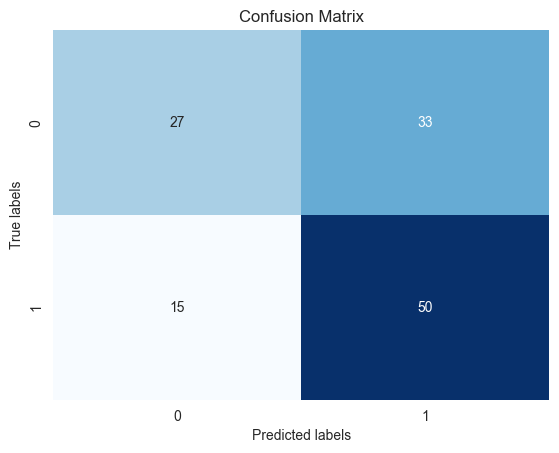

In [13]:
truth = list(test_y)

cm = confusion_matrix(truth, preds)

accuracy = accuracy_score(truth, preds)
print("Accuracy Score:", accuracy)

precision = precision_score(truth, preds)
print("Precision Score:", precision)

recall = recall_score(truth, preds)
print("Recall Score:", recall)

f1 = f1_score(truth, preds)
print("F1 Score: ", f1)

sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.savefig(results_dir + 'confusion_k=' +str(k)+ '.png', dpi=900)
plt.show()